In [12]:
import sys
sys.path.append('../scripts/')
from kf import *

In [22]:
def make_ax(): #axisの準備
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X",fontsize=10)
    ax.set_ylabel("Y",fontsize=10)
    return ax

def draw_trajectory(xs, ax): #軌跡の描画
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")

def draw_observations(xs, zlist, ax): #センサ値の描画
    for s in range(len(xs)):
        if s not in zlist:
            continue

        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi = obs[1][0], obs[1][1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax):
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1] ,e.x2[1]], color="red", alpha=0.5)

def draw_landmarks(ms, ax):
    ax.scatter([ms[k][0] for k in ms], [ms[k][1] for k in ms], s=100, marker="*", color="blue", zorder=100)

def draw(xs, zlist, edges, ms={}):
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    #draw_edges(edges, ax)
    draw_trajectory(xs, ax)
    draw_landmarks(ms, ax)
    plt.show()

In [23]:
def read_data():
    hat_xs = {}
    zlist = {}
    delta = 0.0
    us = {}

    with open("log2.txt") as f: #log2.txtに変えておく
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": 
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": 
                if step not in zlist: 
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
            elif tmp[0] == "delta":   #以下の読み込みを追加
                delta = float(tmp[1])
            elif tmp[0] == "u":
                us[step] = np.array([float(tmp[2]), float(tmp[3])]).T 
                
        return hat_xs, zlist, us, delta #us, deltaも返す

In [24]:
class ObsEdge:
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]):
        assert z1[0] == z2[0] #ランドマークのIDが違ったら処理を止める

        self.t1, self.t2 = t1, t2                   #時刻の記録
        self.x1, self.x2 = xs[t1], xs[t2]    #各時刻の姿勢
        self.z1, self.z2 = z1[1], z2[1]     #各時刻のセンサ値
        
        s1 = math.sin(self.x1[2] + self.z1[1])
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        
        ##残差の計算##
        hat_e = self.x2 - self.x1 + np.array([
            self.z2[0]*c2 - self.z1[0]*c1, 
            self.z2[0]*s2 - self.z1[0]*s1,
            self.z2[1] - self.z2[2] - self.z1[1] + self.z1[2]
        ])
        while hat_e[2] >= math.pi: hat_e[2] -= math.pi*2
        while hat_e[2] <  -math.pi: hat_e[2] += math.pi*2
        
        ##精度行列の作成##
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R1 = - np.array([[c1, -self.z1[0]*s1,  0],
                                     [s1,   self.z1[0]*c1, 0],
                                   [   0,                      1, -1]])
        
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R2 = np.array([[c2, -self.z2[0]*s2, 0],
                                  [s2, self.z2[0]*c2,   0],
                                  [  0,                      1,  -1]])
        
        Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        Omega = np.linalg.inv(Sigma)
        
        ##大きな精度行列と係数ベクトルの各部分を計算##
        B1 = - np.array([[1, 0, -self.z1[0]*s1],
                                    [0, 1, self.z1[0]*c1],
                                    [0, 0, 1]])
        B2 = np.array([[1, 0,  -self.z2[0]*s2],
                                   [0, 1,   self.z2[0]*c2],
                                    [0, 0,  1]])
        
        self.omega_upperleft = B1.T.dot(Omega).dot(B1)
        self.omega_upperright = B1.T.dot(Omega).dot(B2)
        self.omega_bottomleft = B2.T.dot(Omega).dot(B1)
        self.omega_bottomright = B2.T.dot(Omega).dot(B2)
        
        self.xi_upper = - B1.T.dot(Omega).dot(hat_e)
        self.xi_bottom = - B2.T.dot(Omega).dot(hat_e)

In [25]:
import itertools
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {} #ランドマークのIDをキーにして観測された時刻とセンサ値を記録 

    for step in zlist:           #キーを時刻からランドマークのIDへ
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))

    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2)) #時刻のペアを作成
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]

    return edges, landmark_keys_zlist

In [26]:
class MotionEdge:
    def __init__(self, t1, t2, xs, us, delta, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.t1, self.t2 = t1, t2                   #時刻の記録
        self.hat_x1, self.hat_x2 = xs[t1], xs[t2]    #各時刻の姿勢

        nu, omega = us[t2]
        if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける

        M = matM(nu, omega, delta, motion_noise_stds)
        A = matA(nu, omega, delta, self.hat_x1[2])
        F = matF(nu, omega, delta, self.hat_x1[2])
        
        self.Omega = np.linalg.inv(A.dot(M).dot(A.T) + np.eye(3)*0.0001) #標準偏差0.01の雑音を足す
        
        self.omega_upperleft = F.T.dot(self.Omega).dot(F)
        self.omega_upperright = -F.T.dot(self.Omega)
        self.omega_bottomleft = - self.Omega.dot(F)
        self.omega_bottomright = self.Omega
        
        x2 = IdealRobot.state_transition(nu, omega, delta, self.hat_x1)
        self.xi_upper = F.T.dot(self.Omega).dot(self.hat_x2 - x2)
        self.xi_bottom = -self.Omega.dot(self.hat_x2 - x2)

In [27]:
def add_edge(edge, Omega, xi):
    f1, f2 = edge.t1*3, edge.t2*3
    t1 ,t2 = f1 + 3, f2 + 3
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom

1回目の繰り返し: 19.424857331190488
2回目の繰り返し: 12.48992565158308
3回目の繰り返し: 3.5954616926411624
4回目の繰り返し: 2.6224919845317576
5回目の繰り返し: 2.1940853021516897
6回目の繰り返し: 1.6928582316038217
7回目の繰り返し: 1.3082051548158424
8回目の繰り返し: 1.0088682872152437
9回目の繰り返し: 0.778964946652013
10回目の繰り返し: 0.6020865681999181
11回目の繰り返し: 0.46586360993138604
12回目の繰り返し: 0.3607341650156278
13回目の繰り返し: 0.27944886400784585
14回目の繰り返し: 0.21649739534737927
15回目の繰り返し: 0.1676806669638026
16回目の繰り返し: 0.1297857735352452
17回目の繰り返し: 0.10034545235915429
18回目の繰り返し: 0.07745918772319606
19回目の繰り返し: 0.05965940388962222
20回目の繰り返し: 0.0458106370075803
21回目の繰り返し: 0.03503305817051054
22回目の繰り返し: 0.026644147349803568
23回目の繰り返し: 0.020114019437284164
24回目の繰り返し: 0.015031104470991737
25回目の繰り返し: 0.011075751788517234
26回目の繰り返し: 0.007999987014919817


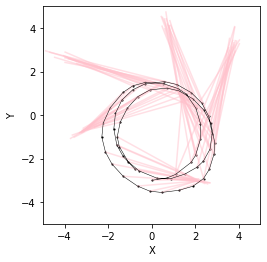

In [28]:
%matplotlib inline
hat_xs, zlist, us, delta = read_data()
dim = len(hat_xs)*3  #軌跡をつなげたベクトルの次元

for n in range(1, 10000):  #繰り返しの回数は適当に大きな値にしておく（終了判定は別途下で）
    ##エッジ、大きな精度行列、係数ベクトルの作成##
    edges, _ = make_edges(hat_xs, zlist)
    
    for i in range(len(hat_xs)-1): #行動エッジの追加
        edges.append(MotionEdge(i, i+1, hat_xs, us, delta))

    
    Omega = np.zeros((dim, dim))
    xi = np.zeros(dim)
    Omega[0:3, 0:3] += np.eye(3)*1000000  #x0の固定

    ##軌跡を動かす量（差分）の計算##
    for e in edges:
        add_edge(e, Omega, xi) #エッジの精度行列、係数ベクトルをOmega, xiに足す

    delta_xs = np.linalg.inv(Omega).dot(xi) #求めた差分
    
    ##推定値の更新##
    for i in range(len(hat_xs)):
        hat_xs[i] += delta_xs[i*3:(i+1)*3]    #差分を足して新たな推定値を作る
        
    ##終了判定###
    diff = np.linalg.norm(delta_xs)           #差分の大きさ（L2ノルム）を求める
    print("{}回目の繰り返し: {}".format(n, diff))
    if diff < 0.01: #閾値
        draw(hat_xs, zlist, edges) #収束したら描画。drawでdraw_edgesを呼び出している行はコメントアウトしておく
        break

In [29]:
class MapEdge:  ###graphbasedslam7mapedge
    def __init__(self, t, z, head_t, head_z, xs):  #head_t、head_zは最初に対象のランドマークを観測した時の時刻とセンサ値
        self.x = xs[t]
        self.z = z
        
        self.m = self.x + np.array([
            z[0]*math.cos(self.x[2] + z[1]),
            z[0]*math.sin(self.x[2] + z[1]),
            - xs[head_t][2] + z[1] - head_z[1] - z[2] + head_z[2]
        ]).T
        
        while self.m[2] >= math.pi: self.m[2] -= math.pi*2
        while self.m[2] <  -math.pi: self.m[2] += math.pi*2

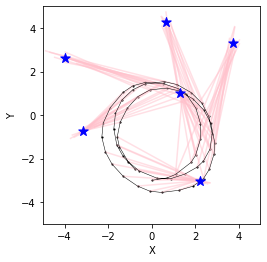

In [30]:
%matplotlib inline

_, zlist_landmark = make_edges(hat_xs, zlist)

ms = {}
for landmark_id in zlist_landmark:
    edges = []
    head_z = zlist_landmark[landmark_id][0] #最初の観測（ランドマークの向きθの計算に利用）
    for z in zlist_landmark[landmark_id]:
        edges.append(MapEdge(z[0], z[1][1], head_z[0], head_z[1][1], hat_xs))
        
    ms[landmark_id] = np.mean([e.m for e in edges], axis=0)
    
draw(hat_xs, zlist, edges, ms)